# KSSL

> Various Transforms to be piped to create a DataLoader

In [ ]:
#| default_exp data.transforms.kssl

In [ ]:
#| export
from __future__ import annotations
from fastai.vision.all import *
from fastai.data.all import *
from fastcore.basics import patch
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

## Input (spectra)

In [ ]:
#|eval: false
path = Path('../_data/kssl-mirs-v2')

In [ ]:
#def is_valid(path):
#    is_analyte_pos = AnalytesTfm(analytes=[725])(path).item() > 0
#    has_spectra = len(get_spectra_files(path)) > 0
#    return is_analyte_pos and has_spectra

In [ ]:
#%%time 
#mask = parallel(is_valid, path.ls(), n_workers=8, progress=True)
#paths = path.ls()[mask]

In [ ]:
#|eval: false
#@paths = L()
#for p in tqdm(path.ls()):
#    is_analyte_pos = AnalytesTfm(analytes=[725])(p).item() > 0
#    has_spectra = len(get_spectra_files(p)) > 0
#    if is_analyte_pos and has_spectra: paths.append(p)

In [ ]:
#| export
#@Transform
#def get_spectra_files(path:Path, # Directory that contains spectra replicates and wet chemistry
#                     ) -> L: # List of spectra replicates (if any) file paths in the directory
#    "Return list of paths to spectra `.csv` files"
#    return L(fname for fname in path.ls() if re.match('\d', fname.name))

In [ ]:
#|eval: false
#fn = path.ls()[0]
#get_spectra_files(fn)

In [ ]:
#wn = np.arange(4000, 600, -2); wn

In [ ]:
#|eval: false
path.ls()

(#46305) [Path('../_data/kssl-mirs-v2/180338'),Path('../_data/kssl-mirs-v2/172221'),Path('../_data/kssl-mirs-v2/177753'),Path('../_data/kssl-mirs-v2/184798'),Path('../_data/kssl-mirs-v2/53759'),Path('../_data/kssl-mirs-v2/74947'),Path('../_data/kssl-mirs-v2/176681'),Path('../_data/kssl-mirs-v2/1855'),Path('../_data/kssl-mirs-v2/175004'),Path('../_data/kssl-mirs-v2/34499')...]

In [ ]:
#| export
class Spectra(Tensor):
    def __init__(self, x):
        self.x = x
        
    def show(self, ctx=None, wn=np.arange(4000, 600, -2), figsize=(12,2), **kwargs):
        spectra = self
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        ctx.set_xlim(np.max(wn), np.min(wn))
        ctx.set(xlabel='Wavenumber', ylabel='Absorbance')
        ctx.set_axisbelow(True)
        for spectrum in spectra:
            _ = ctx.plot(wn, spectrum, c='steelblue', lw=1)
        ctx.grid(True, which='both')
        return ctx    

In [ ]:
#| export
class Analyte(Tensor, ShowTitle):
    def __init__(self, y):
        self.y = y

In [ ]:
#| export
class SpectraTfm(Transform):
    "Transform folder path into a torch array of dimension: (n_replicates, n_wavenumbers)"
    def encodes(self, 
                o:Path # Path to directory containing both spectra and analyte(s) measurement
               ):
        o = L(fname for fname in o.ls() if re.match('\d', fname.name))
        n = pd.read_csv(o[0]).shape[0]
        m = len(o)
        x = np.empty((m,n))
        for i, fname in enumerate(o):
            x[i,:] = pd.read_csv(fname)['absorbance'].values
        return Spectra(torch.Tensor(x)) 

In [ ]:
#| export   
class AnalyteTfm(Transform):
    "Transform a folder path into a tensor of soil analyte(s) measurement"
    def __init__(self, 
                 analytes:list|None=None):
        self.analytes = analytes
        
    def encodes(self, 
                o:Path # Path to directory containing both spectra and analyte(s) measurement
               ):
        path_target = [f for f in o.ls() if re.match('target', f.name)][0]
        df = pd.read_csv(path_target)
        if self.analytes:
            df = df[df.analyte.isin(self.analytes)]
        return Analyte(df['value'].values)

In [ ]:
#| export
class RandWAvgTfm(Transform):
    def encodes(self, x:Spectra):
        n = len(x)
        return torch.matmul(self._weights(n), x)  
    def _weights(self, n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0)

In [ ]:
#| export
class AvgTfm(Transform):
    def encodes(self, x:Spectra):
        return torch.mean(x, dim=0, keepdim=True)

In [ ]:
#| export
class SNVTfm(Transform):
    def encodes(self, x:Spectra):
        mean, std = torch.mean(x), torch.std(x)
        return (x - mean)/std

In [ ]:
#| export
class NormalizeTfm(Transform):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def encodes(self, x:Spectra):
        return (x - self.mean)/self.std

In [ ]:
#| export
def SpectraBlock():
    return TransformBlock(type_tfms=SpectraTfm())

In [ ]:
#| export
def AnalyteBlock(analytes):
    return TransformBlock(type_tfms=AnalyteTfm(analytes))

In [ ]:
#| export
class Spectra(Tensor): 
    def show(self, ctx=None, wn=np.arange(4000, 600, -2), figsize=(12,3), **kwargs):
        spectra = self
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        #ctx.imshow(im, **{**self._show_args, **kwargs})
        ctx.set_xlim(np.max(wn), np.min(wn))
        ctx.set(xlabel='Wavenumber', ylabel='Absorbance')
        ctx.set_axisbelow(True)
        for spectrum in spectra:
            _ = ctx.plot(wn, spectrum, c='steelblue', lw=1)
        ctx.grid(True, which='both')
        return ctx

In [ ]:
#| export
@Transform
def to_spectra(paths:L, # List of spectra file paths
              ) -> Spectra: # Spectra
    "Transform list of spectra file paths to a torch array of dimension: (n_replicates, n_wavenumbers)"
    n = pd.read_csv(paths[0]).shape[0]
    m = len(paths)
    x = np.empty((m,n))
    for i, fname in enumerate(paths):
        x[i,:] = pd.read_csv(fname)['absorbance'].values
    return Spectra(x)

Spectra([[0.1680, 0.1682, 0.1684,  ..., 1.4982, 1.4934, 1.4900],
         [0.1742, 0.1743, 0.1745,  ..., 1.5318, 1.5263, 1.5215],
         [0.1706, 0.1708, 0.1710,  ..., 1.5089, 1.5031, 1.4992],
         [0.2243, 0.2245, 0.2248,  ..., 1.5664, 1.5592, 1.5532]])


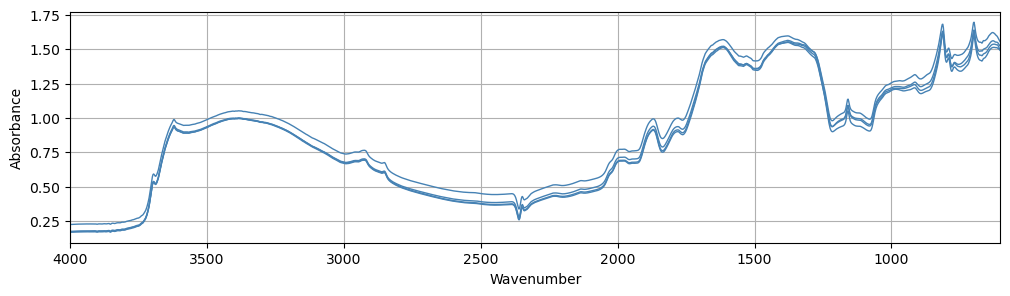

In [ ]:
#|eval: false
pipe = Pipeline([get_spectra_files, to_spectra])
spectra = pipe(fn)
print(spectra)
pipe.show(spectra);

In [ ]:
#| export
@Transform
def rand_w_avg(x: Spectra, # Spectra replicates (n_replicates, n_wavenumbers)
              ) -> Spectra: # Random weighted averaged spectrum
    "Transform spectra replicates taking their random weighted averages for data augmentation"
    n = len(x)
    def weights(n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0)
    return torch.matmul(weights(n), x)

Spectra([[0.1846, 0.1849, 0.1851,  ..., 1.5240, 1.5182, 1.5138]])


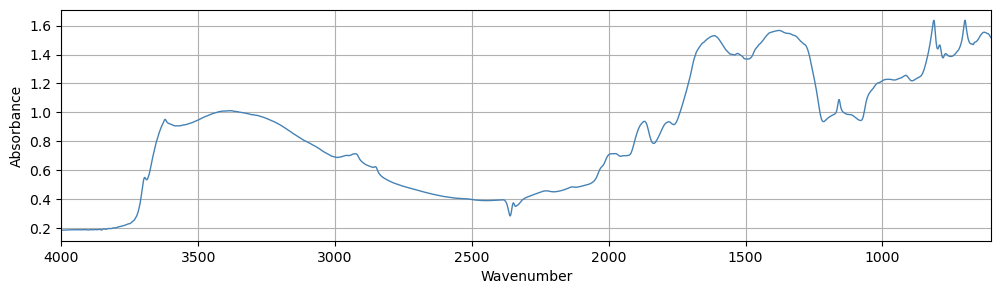

In [ ]:
#|eval: false
pipe = Pipeline([get_spectra_files, to_spectra, rand_w_avg])
spectra = pipe(fn)
print(spectra)
pipe.show(spectra);

In [ ]:
#| export
@Transform
def avg(x: Spectra, # Spectra replicates (n_replicates, n_wavenumbers)
       ) -> Spectra: # Averaged spectrum
    "Transform spectra replicates taking their average"
    return torch.mean(x, dim=0, keepdim=True)

Spectra([[0.1842, 0.1845, 0.1847,  ..., 1.5263, 1.5205, 1.5160]])


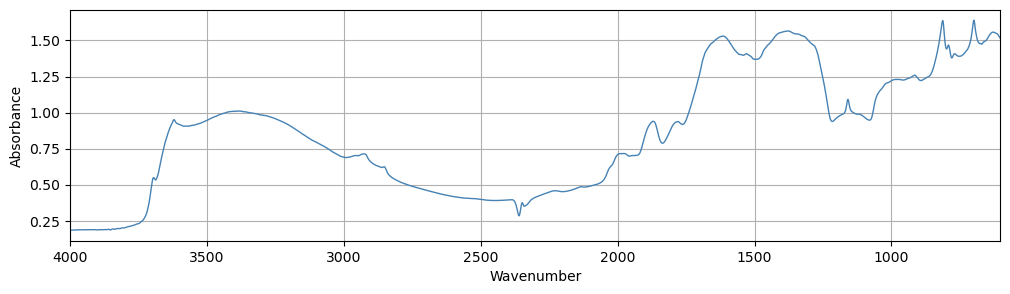

In [ ]:
#|eval: false
pipe = Pipeline([get_spectra_files, to_spectra, avg])
spectra = pipe(fn)
print(spectra)
pipe.show(spectra);

In [ ]:
#| export
@Transform
def snv(x: Spectra, # Spectrum 
       ) -> Spectra: # Standard Normal Variate of spectrum
    "Standard Normal Variate Transform of input spectrum"
    mean, std = torch.mean(x), torch.std(x)
    return (x - mean)/std

Spectra([[-1.6134, -1.6129, -1.6124,  ...,  1.6146,  1.6005,  1.5896]])


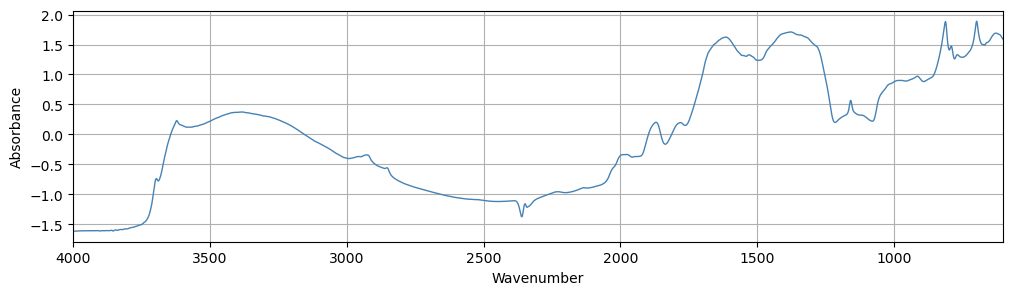

In [ ]:
#|eval: false
pipe = Pipeline([get_spectra_files, to_spectra, avg, snv])
spectra = pipe(fn)
print(spectra)
pipe.show(spectra);

## Target (Soil properties)

In [ ]:
#| export
class LogTfm(Transform):
    def encodes(self, y:Analyte):
        return torch.log10(y)

In [ ]:
#| export
class Analyte(Tensor): 
    def show(self, ctx=None, **kwargs):
        analytes = self

In [ ]:
#| export
class AnalytesTfm(Transform):
    def __init__(self, 
                 analytes:list|None=None): 
        self.analytes = analytes

In [ ]:
#| export
@AnalytesTfm
def encodes(self, 
            path: Path, # Path to directory containing both spectra and analyte(s) measurement
           ):
    "Transform a path to a directory into a tensor of soil analyte(s) measurement"
    path_target = [f for f in path.ls() if re.match('target', f.name)][0]
    df = pd.read_csv(path_target)
    if self.analytes:
        df = df[df.analyte.isin(self.analytes)]
    return Analyte(df['value'].values)

In [ ]:
#|eval: false
AnalytesTfm(analytes=[725])(path.ls()[0])

Analyte([2.8077])

In [ ]:
AnalytesTfm(analytes=[725])(path.ls()[0]).show()

Analyte([2.8077])


In [ ]:
#|eval: false
# Or as a TfmdLists pipeline
tls = TfmdLists(path.ls(), [AnalytesTfm(analytes=[725]), torch.log10])
tls[0]

Analyte([0.4484])

In [ ]:
#t = np.array([AnalytesTfm(analytes=[725])(fname).item() for fname in path.ls()])
#np.log10(t.min()), np.log10(t.max())

## How to use these transforms?

In [ ]:
#|eval: false
dblock = DataBlock(blocks=(SpectraBlock, AnalyteBlock(analytes=[725])),
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), NormalizeTfm(mean=0.8813, std=0.4324),
                              LogTfm()])

dls = dblock.dataloaders(path.ls(), 
                         bs=16)

dls.show_batch()

1. First create two // pipes (one for the features and one for the targets):

In [ ]:
#|eval: false
x_tfms = [get_spectra_files, to_spectra, rand_w_avg]
y_tfms = [AnalytesTfm(analytes=[725]), torch.log10]

2. Create your splits and create a Fastai `Datasets`:

In [ ]:
#|eval: false
splits = RandomSplitter(seed=42)(path.ls())
dsets = Datasets(path.ls(), [x_tfms, y_tfms], splits=splits)

3. Then you get your Dataloader:

In [ ]:
#|eval: false
dls = dsets.dataloaders(bs=16)

In [ ]:
#|eval: false
dls.train.one_batch()[0].shape

torch.Size([256, 1, 1700])

In [ ]:
#|eval: false
#dls.train.one_batch()[1]

In [ ]:
x, y = dls.train.one_batch()

In [ ]:
x.shape

torch.Size([256, 1, 1700])

In [ ]:
x.mean(dim=[0,2]), x.std(dim=[0,2])

(Spectra([0.9019]), Spectra([0.4334]))

In [ ]:
x.mean(dim=[0,2]), x.std(dim=[0,2])
    #,x.std(dim=[0,2,3])

(Spectra([0.9242]), Spectra([0.4409]))

In [ ]:
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

In [ ]:
#for s, a in dls.train:
#    print(s.shape)
#    print(a.shape)

In [ ]:
dls.show_batch(max_n=4)

In [ ]:
x, y = dls.train.one_batch()

In [ ]:
x.shape

torch.Size([16, 1, 1700])

In [ ]:
x.size(1)

1

In [ ]:
x.view(16, 1, -1).shape

torch.Size([16, 1, 1700])

In [ ]:
x.mean(

In [ ]:
mean = 0.
std = 0.
nb_samples = 0.

for x, y in dls.train:
    batch_samples = x.size(0)
    x.view(batch_samples, x.size(1)
    #print(x.shape)
    break

16


In [ ]:
x = np.array([1, 2, 3, 4, 5, 8, 12, 45, 33])

In [ ]:
x.mean()

12.555555555555555

In [ ]:
n = len(x)
avg = 0
for el in x:
    avg += el/n
print(avg)

12.555555555555555


In [ ]:
16,1700

In [ ]:
N,C,H,W

In [ ]:
x = torch.randn(100, 3, 24, 24)
batch_samples = x.size(0); print(batch_samples)
x = x.view(batch_samples, x.size(1), -1); print(x.shape)


100
torch.Size([100, 3, 576])


In [ ]:
x.mean(2).shape

torch.Size([100, 3])

In [ ]:
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=kuzand
mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.randn(100, 3, 24, 24)
        
    def __getitem__(self, index):
        x = self.data[index]
        return x

    def __len__(self):
        return len(self.data)
    

dataset = MyDataset()
loader = DataLoader(
    dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

NameError: name 'Dataset' is not defined

In [ ]:
dblock = DataBlock(blocks=(SpectraBlock, AnalyteBlock(analytes=[725])),
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), NormalizeTfm(mean=0.8813, std=0.4324),
                              LogTfm()])

dls = dblock.dataloaders(path.ls(), 
                         bs=16)

model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())
learn.lr_find()
learn.fit_one_cycle(40, 1e-3)